In [25]:
import pandas as pd
from DataVisualization import DataVisualization

# Modelo de análise das métricas RFV:

Segmentando a base de clientes e personalizando as campanhas de marketing.

## DataFrame:

In [26]:
path = r'../data/data.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    decimal='.',
    sep=',',
    encoding='unicode_escape'
)

In [27]:
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Código:

In [28]:
class CustomerProfiles(DataVisualization):
    pass


if __name__ == '__main__':
    customer_profiles = CustomerProfiles()

## Output:

### Data Understanding:

In [29]:
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [30]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [31]:
customer_profiles.descrição(
    dataframe=df
)

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


In [32]:
customer_profiles.verificando_valores_nulos(
    dataframe=df
)

,Quantidade,Porcentagem
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,1454,0.27%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,135080,24.93%
Country,0,0.00%


In [33]:
customer_profiles.verificando_valores_duplicados(
    dataframe=df
)

,Quantidade,Porcentagem
InvoiceNo,516009,95.22%
StockCode,537839,99.25%
Description,537685,99.22%
Quantity,541187,99.87%
InvoiceDate,518649,95.71%
UnitPrice,540279,99.70%
CustomerID,537536,99.19%
Country,541871,99.99%


### Data Visualization:

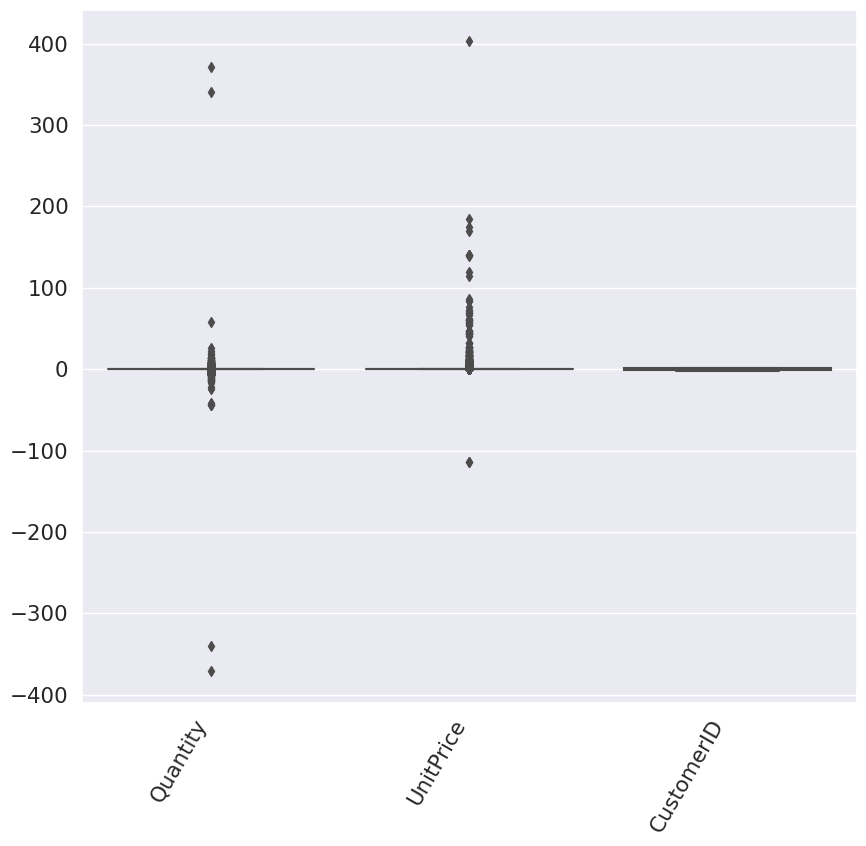

In [34]:
customer_profiles.gráfico_boxplot(
    dataframe=df,
    figsize=(10, 9)
)